# FDRI catchment gauge record vs gridded data at Carreg Wen

The rain gauge record is from Carreg-wen, Pembrokeshire

## Table of contents
[1 Analysis](#1-Analysis)  

In [87]:
import numpy as np
import polars as pl
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [2]:
CARREG_COORDS = {"Easting": 282903, "Northing": 288549}
RAIN_COL = "rain_mm"

In [3]:
haduk_carreg = xr.open_mfdataset(['hadukgrid_data/hadukgrid_1km_carreg3by3_19760101_19920831.nc',\
                 'hadukgrid_data/hadukgrid_1km_carreg3by3_19920901_20091231.nc'])
assert haduk_carreg['projection_x_coordinate'].size == 3, "Should be 3 by 3 km grid box"
haduk_carreg = haduk_carreg.rename({'rainfall': RAIN_COL})
haduk_carreg

<xarray.Dataset> Size: 2MB
Dimensions:                       (time: 12419, projection_y_coordinate: 3,
                                   projection_x_coordinate: 3, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 99kB 1976-01-01T12:00...
  * projection_y_coordinate       (projection_y_coordinate) float64 24B 2.875...
  * projection_x_coordinate       (projection_x_coordinate) float64 24B 2.815...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 72B dask.array<chunksize=(3, 3), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 72B dask.array<chunksize=(3, 3), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    rain_mm                       (time, projection_y_coordinate, projection_x_coordinate) float64 894kB dask.array<chunksize=(6088, 3, 3), meta=np.ndarray>
    transverse_mercator           (time) int32 50kB dask.array<chunksize=(6088,), meta=np.ndarray>
    time_bnds                     (time, bnds) datetime64[ns] 199kB dask.array<chunksize=(6088, 2), meta=np.ndarray>
    projection_y_coordinate_bnds  (time, projection_y_coordinate, bnds) float64 596kB dask.array<chunksize=(6088, 3, 2), meta=np.ndarray>
    projection_x_coordinate_bnds  (time, projection_x_coordinate, bnds) float64 596kB dask.array<chunksize=(6088, 3, 2), meta=np.ndarray>
Attributes:
    comment:        Daily resolution gridded climate observations
    creation_date:  2024-05-17T13:12:49
    frequency:      day
    institution:    Met Office
    references:     doi: 10.1002/gdj3.78
    short_name:     daily_rainfall
    source:         HadUK-Grid_v1.3.0.0
    title:          Gridded surface climate observations data for the UK
    version:        v20240514
    Conventions:    CF-1.7

In [20]:
## Compute rainfall mean over Carreg-wen (3 * 3 km)
haduk_carreg_mean = haduk_carreg[RAIN_COL].mean(('projection_x_coordinate', 'projection_y_coordinate'))
haduk_carreg_mean = pl.from_pandas(haduk_carreg_mean.to_dataframe().reset_index()) ## convert to polars
haduk_carreg_mean = haduk_carreg_mean.rename({RAIN_COL: f'{RAIN_COL}_mean'})

#  Closest 1km grid cell to gauge
haduk_carreg_1cell = haduk_carreg.sel(projection_x_coordinate=282500+0, projection_y_coordinate=288500+0)
haduk_carreg_1cell = haduk_carreg_1cell[RAIN_COL].drop_vars(('projection_y_coordinate', 'projection_x_coordinate', 'latitude', 'longitude')) ## drop unnecessary vars
haduk_carreg_1cell = pl.from_pandas(haduk_carreg_1cell.to_dataframe().reset_index()) ##convert to polars
haduk_carreg_1cell = haduk_carreg_1cell.rename({RAIN_COL: f'{RAIN_COL}_1cell'})

In [21]:
## join data together
haduk_carreg_all = haduk_carreg_mean.join(haduk_carreg_1cell, on='time')

## overwrite value to be 9 am NOTE: messy but necessary for how the data has been stored
haduk_carreg_all = haduk_carreg_all.with_columns(
    pl.datetime(
        pl.col("time").dt.year(),
        pl.col("time").dt.month(),
        pl.col("time").dt.day(),
        9,
        pl.col("time").dt.minute(),
        pl.col("time").dt.second(),
    ).alias('time')
)
haduk_carreg_all

time,rain_mm_mean,rain_mm_1cell
datetime[μs],f64,f64
1976-01-01 09:00:00,53.82373,55.60586
1976-01-02 09:00:00,33.190642,34.252948
1976-01-03 09:00:00,4.558701,4.645649
1976-01-04 09:00:00,40.954625,42.494596
1976-01-05 09:00:00,9.248094,9.494617
…,…,…
2009-12-27 09:00:00,3.978755,4.08665
2009-12-28 09:00:00,0.647344,0.664587
2009-12-29 09:00:00,22.786502,23.384517


In [22]:
## Load gauge data
gauge_carreg = pl.read_csv('gauge_data/plynlimon-jwk-2024-infilled_carreg_rf.csv', skip_rows=13,\
                          try_parse_dates=True, columns=[0, 1], new_columns=["time", f'{RAIN_COL}_gauge'])
gauge_carreg

time,rain_mm_gauge
datetime[μs],f64
1976-01-02 09:00:00,null
1976-01-03 09:00:00,0.5
1976-01-04 09:00:00,62.0
1976-01-05 09:00:00,12.5
1976-01-06 09:00:00,5.0
…,…
2010-12-27 09:00:00,0.0
2010-12-28 09:00:00,20.0
2010-12-29 09:00:00,1.5


## Join data together

In [23]:
carreg_rain_data = gauge_carreg.join(haduk_carreg_all, on='time')
carreg_rain_data = carreg_rain_data.select(['time', f'{RAIN_COL}_gauge', f'{RAIN_COL}_1cell', f'{RAIN_COL}_mean']) # reorder
carreg_rain_data = carreg_rain_data.drop_nans() # drop_nans
carreg_rain_data.head(10)

time,rain_mm_gauge,rain_mm_1cell,rain_mm_mean
datetime[μs],f64,f64,f64
1976-01-03 09:00:00,0.5,4.645649,4.558701
1976-01-04 09:00:00,62.0,42.494596,40.954625
1976-01-05 09:00:00,12.5,9.494617,9.248094
1976-01-06 09:00:00,5.0,2.469852,2.285885
1976-01-07 09:00:00,3.5,0.629355,0.769007
1976-01-08 09:00:00,2.25,2.157339,1.928009
1976-01-09 09:00:00,34.25,42.706809,39.518538
1976-01-10 09:00:00,24.0,21.812376,20.099545
1976-01-11 09:00:00,0.5,0.207547,0.219521


# 1 Analysis

In [24]:
carreg_annual_mean = carreg_rain_data.group_by_dynamic('time', every='1y').agg(pl.all().mean())
carreg_annual_sum = carreg_rain_data.group_by_dynamic('time', every='1y').agg(pl.all().sum())

carreg_annual_mean.head()

time,rain_mm_gauge,rain_mm_1cell,rain_mm_mean
datetime[μs],f64,f64,f64
1976-01-01 00:00:00,5.061676,5.052509,4.823164
1977-01-01 00:00:00,8.189726,7.894609,7.600082
1978-01-01 00:00:00,7.179452,7.211537,6.884219
1979-01-01 00:00:00,9.094521,8.194458,7.84368
1980-01-01 00:00:00,8.189891,7.725199,7.407256


In [25]:
## calc_difference
carreg_annual_mean_diff = carreg_annual_mean.with_columns(
    (pl.col(f'{RAIN_COL}_gauge') - pl.col(f'{RAIN_COL}_1cell')).alias("diff_1cell"),
    (pl.col(f'{RAIN_COL}_gauge') - pl.col(f'{RAIN_COL}_mean')).alias("diff_mean")
)

carreg_annual_sum_diff = carreg_annual_sum.with_columns(
    (pl.col(f'{RAIN_COL}_gauge') - pl.col(f'{RAIN_COL}_1cell')).alias("diff_1cell"),
    (pl.col(f'{RAIN_COL}_gauge') - pl.col(f'{RAIN_COL}_mean')).alias("diff_mean")
)

Text(0.5, 0.98, 'Annual mean')

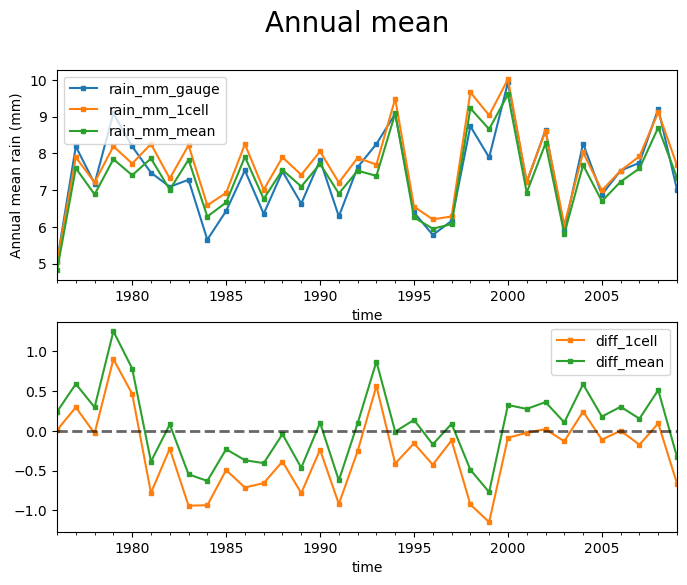

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
carreg_annual_mean.to_pandas().set_index('time').plot(marker='s', markersize=3, ax=axes[0])
carreg_annual_mean_diff.to_pandas().set_index('time')[['diff_1cell', 'diff_mean']].plot(marker='s', markersize=3, ax=axes[1], color=('C1', 'C2'))

axes[0].set_ylabel("Annual mean rain (mm)")
axes[1].axhline(0, color='k', linewidth=2, alpha=.6, linestyle='--')
plt.suptitle("Annual mean", size=20)

Text(0.5, 0.98, 'Annual sum')

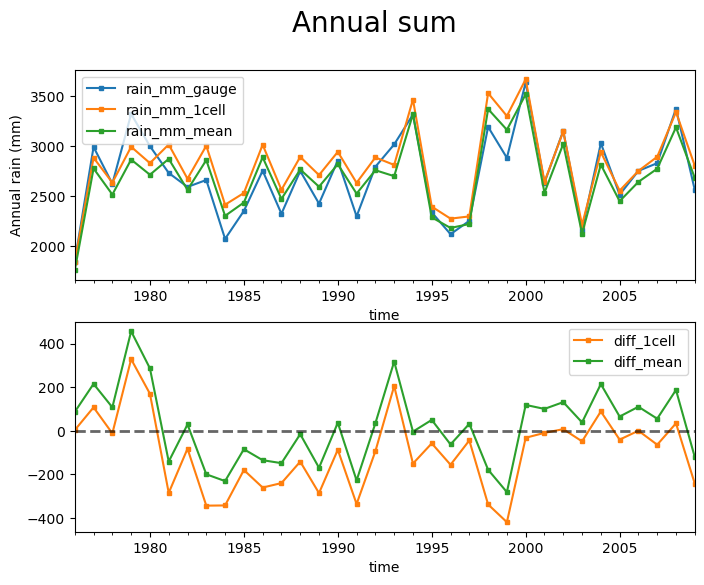

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
carreg_annual_sum.to_pandas().set_index('time').plot(marker='s', markersize=3, ax=axes[0])
carreg_annual_sum_diff.to_pandas().set_index('time')[['diff_1cell', 'diff_mean']].plot(marker='s', markersize=3, ax=axes[1], color=('C1', 'C2'))

axes[0].set_ylabel("Annual rain (mm)")
axes[1].axhline(0, color='k', linewidth=2, alpha=.6, linestyle='--')
plt.suptitle("Annual sum", size=20)

## double mass plot

In [68]:

carreg_rain_data_cumsum = carreg_rain_data.with_columns(
    pl.all().exclude("time").cum_sum()
)


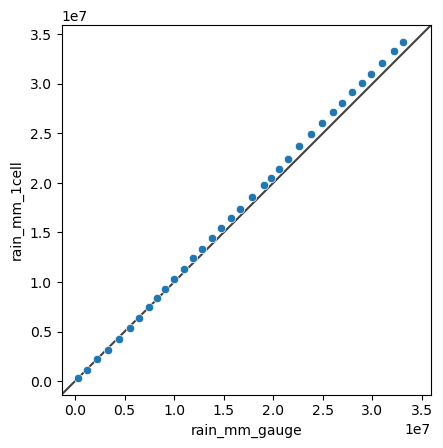

In [98]:
#  = carreg_rain_data_cumsum.group_by_dynamic('time', every='1y').agg(pl.all().sum())
data_to_plot = carreg_rain_data_cumsum.group_by_dynamic('time', every='12mo').agg(pl.all().sum())


fig, ax = plt.subplots(1)
sns.scatterplot(x='rain_mm_gauge', y='rain_mm_1cell', data=data_to_plot, ax=ax)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

## Spatial variation of HADUK

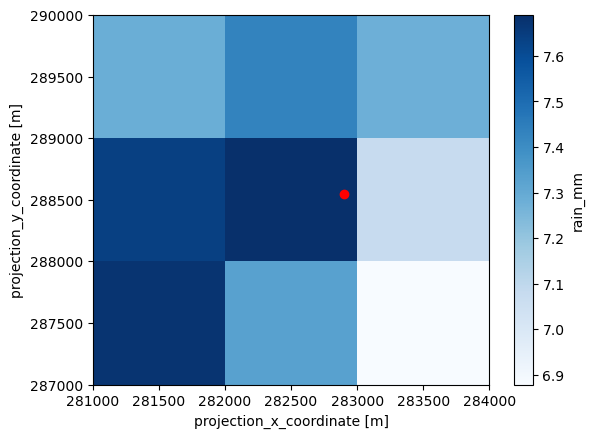

In [111]:
haduk_carreg[RAIN_COL].mean('time').plot(cmap='Blues')
plt.plot(CARREG_COORDS['Easting'], CARREG_COORDS['Northing'], 'ro')

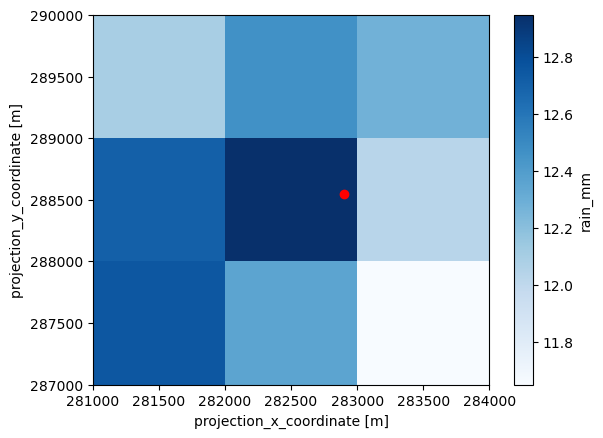

In [109]:
haduk_carreg[RAIN_COL].std('time').plot(cmap='Blues')
plt.plot(CARREG_COORDS['Easting'], CARREG_COORDS['Northing'], 'ro')